<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC4</p>
<p style="margin: 0; text-align:right;">2017-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 4: Combinació de classificadors

En aquesta pràctica veurem diferents mètodes de combinació de classificadors aplicats sobre el conjunt de dades [EMNIST](https://www.nist.gov/itl/iad/image-group/emnist-dataset).

<ol start="0">
  <li>Càrrega de dades</li>
  <li>Combinació paral.lela de classificadors base similars
  <br>1.1 Bagging
  <br>. 1.1.1 Random Forest simple
  <br>. 1.1.2 Out-of-bag
  <br>. 1.1.3 Probabilitat per classe
  <br>. 1.1.4 Importància de les variables
  <br>. 1.1.5 Número de classificadors
  <br>. 1.1.6 Volum de dades
  <br>1.2 Boosting</li>
  <li>Combinació seqüencial de claxsificadors base diferents
  <br>2.1 Stacking
  <br>2.2 Cascading
  <br>. 2.2.1 Cascading simple
  <br>. 2.2.2 Cascading amb variables addicionals</li>
</ol>

**Important: Cadascun dels exercicis pot suposar varis minuts d'execució, pel que l'entrega s'ha de fer en format notebook i en format html on es vegi el codi i els resultats, juntament amb els comentaris de cada exercici. Per exportar el notebook a html es pot fer des del menú File $\to$ Download as $\to$ HTML.**

# 0. Càrrega de dades

Utilitzarem les mateix dades que en la pràctica anterior, PAC 3, que són les 5.000 imatges EMMNIST, corresponents a 5 caràcters diferents: "A", "B", "C", "D" i "E".

El següent codi carregarà les imatges:

In [1]:
import pickle
import numpy as np

with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["A", "B", "C", "D", "E"]

print("Dimensions del vector d'imatges: {}".format(images.shape))
print("Dimensions del vector d'etiquetes: {}".format(labels.shape))

Dimensions del vector d'imatges: (5000, 784)
Dimensions del vector d'etiquetes: (5000,)


Amb el següent codi podem veure un exemple d'imatge de cada una de les classes. Per fer això, ajustem el vector de 784 dimensions que representa cada imatge en una matriu de mida 28x28 i la transposem per a mostrar-la:

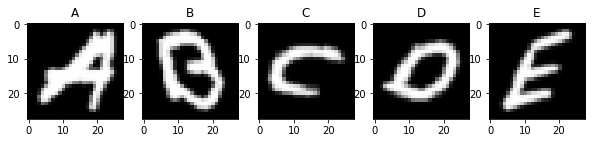

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28).transpose(), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

Reduim la dimensionalitat usant PCA i dividim les dades, tal com hem fet en el PAC 3, en 4.000 imatges pel procés d'entrenament i 1.000 imatges per a test.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=2017, stratify=labels)

pca = PCA(n_components=100, random_state=2017)
pca_fit = pca.fit(X_train)
X_train_pca = pca_fit.transform(X_train)
X_test_pca = pca_fit.transform(X_test)

def proporcio_etiquetes(y):
    _, count = np.unique(y, return_counts=True)
    return np.true_divide(count, y.shape[0])
    

print("Número d'imatges per a entrenar: {}".format(X_train_pca.shape[0]))
print("Número d'imatges per a test: {}".format(X_test_pca.shape[0]))

print("Proporció de les etiquetes en el conjunt original: {}".format(proporcio_etiquetes(labels)))
print("Proporció de les etiquetes en el conjunt d'entrenament: {}".format(proporcio_etiquetes(y_train)))
print("Proporció de les etiquetes en el conjunt de test: {}".format(proporcio_etiquetes(y_test)))

Número d'imatges per a entrenar: 4000
Número d'imatges per a test: 1000
Proporció de les etiquetes en el conjunt original: [0.2 0.2 0.2 0.2 0.2]
Proporció de les etiquetes en el conjunt d'entrenament: [0.2 0.2 0.2 0.2 0.2]
Proporció de les etiquetes en el conjunt de test: [0.2 0.2 0.2 0.2 0.2]


# 1. Combinació paral.lela de classificadors base similars

## 1.1 Bagging

### 1.1.1 Random forest simple (1 punt)

La idea bàsica del *bagging* és utilitzar el conjunt d'entrenament original per generar centenars o milers de conjunts similars usant mostreig amb reemplaçament. En aquest concepte està basat l'algoritme *Random Forest*, la combinació de diferents arbres de decisió, cada un entrenat amb una realització (mostreig) diferent de les dades. La decisió final del classificador combinat (la *Random Forest*) es pren per majoria, donant el mateix pes a totes les decisions parcials preses pels classificadores base (els arbres).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Usant els conjunts *X_train_pca* i *y_train_pca*, entrenar un model *Random Forest* amb 100 arbres de decisió i estimar la precisió del model amb una estratègia de *cross-validation* en els mateixos conjunts.
<hr>
Suggeriment: usar els mòduls *RandomForestClassifier* i *cross_val_score* de sklearn. Per aprendre més sobre *cross validation* i sobre com usar aquests mòduls, us recomanem els següents enllaços:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br>
http://scikit-learn.org/stable/modules/cross_validation.html<br>
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

Un bosc aleatori és un estimador meta que s'adapta a una sèrie de classificadors d'arbres de decisió en diverses sub-mostres del conjunt de dades i utilitza una mitjana per millorar la precisió predictiu i el control de l'execució excessiva. La mida de sub submissió és sempre igual que la mida original de la mostra d'entrada.

A Scikit-Learn, és un conjunt optimitzat d'arbres de decisió aleatoris s'implementa a l'estimador RandomForestClassifier, que s'ocupa automàticament de tota l'assignació aleatoritzada. Tot el que s'ha de fer és seleccionar una sèrie d'estimadors i, de forma molt ràpida (en paral·lel, si es desitja) s'ajusti al conjunt dels arbres:

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
          
n_estimators = 100
forest = RandomForestClassifier(warm_start=True, oob_score=True, random_state=2007)

error_rate = []

for i in range(1, n_estimators + 1):
    forest.set_params(n_estimators=i)
    forest.fit(X_train_pca, y_train)
    
    oob_error = 1 - forest.oob_score_
    error_rate.append((i, oob_error))
    
forest.oob_score_

0.91325

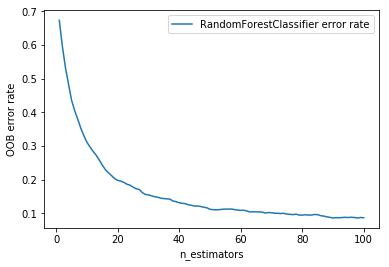

In [5]:
xs, ys = zip(*error_rate)
plt.plot(xs, ys, label='RandomForestClassifier error rate')
    
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Podem veure que a mida que augmenten el els models aleatoris fins 100, també baixa l'error, aproximadament a 80 models aleatoris, l'error gairebe no disminueix.

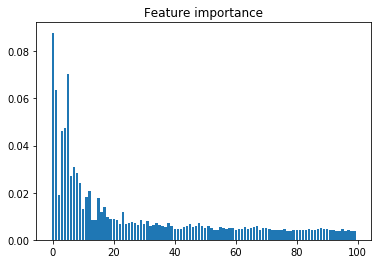

In [6]:
# plot feature importance
plt.bar(range(len(forest.feature_importances_)), forest.feature_importances_)
plt.title('Feature importance')
plt.show()

Amb Scikit-Learn, el conjunt optimitzat d'arbres de decisió aleatoris s'implementa amb RandomForestClassifier, que s'ocupa automàticament de tota l'assignació aleatoritzada.

In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest, X_train_pca, y_train, cv=5)
print(scores)

print("Precisió: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.92    0.92875 0.9225  0.92375 0.93875]
Precisió: 0.93 (+/- 0.01)


La precisió del model és 93%

### 1.1.2 Out-of-bag (1 punt)

Una avantatge del *bagging* usat en el *Random Forest* és que cada un dels arbres de decisió ha sigut entrenat amb una combinació diferent de les dades (mostreig amb reemplaçament), o sigui que cada un dels arbres no ha vist una determinada part de les dades originals. Això defineix una espècie de conjunt de test per a cada un dels arbres, anomenat *out-of-bag*, que pot ser usat per estimar l'error del model sense necessitat d'usar el conjunt de test real creat previament, ni d'usar estratègies de *cross-validation*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Usant els conjunts *X_train_pca* i *y_train_pca*, entrenar un model Random Forest amb 100 arbres de decisió. Mostrar la precisió d'aquest model en l'*out-of-bag* i en el conjunt *X_test_pca*.
<hr>
Suggeriment: usar el mòdul *RandomForestClassifier* de sklearn. Per aprendre més sobre *out-of-bag* i sobre com usar aquest mòdul (incluïnt l'atribut *oob&#95;score_*), us recomanem els següents enllaços:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br>
http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
</div>

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = RandomForestClassifier()
bag = BaggingClassifier(tree, max_samples=0.8,
                        oob_score=True, random_state=2008)

n_estimators = 100

error_rate_bag = []

for i in range(1, n_estimators + 1):
    bag.set_params(n_estimators=i)
    bag.fit(X_train_pca, y_train)
    
    oob_error_bag = 1 - bag.oob_score_
    error_rate_bag.append((i, oob_error_bag))

print(bag.oob_score_)
print('\nLa precisió del nostre classificador és %d%%, [%s]' % (bag.oob_score_ * 100, bag.oob_score_))

0.931

La precisió del nostre classificador és 93%, [0.931]


Hem calculat l'out-of-bag en la llista error_rate_bag i podem comprar l'error gràficament, i com podem veure la precisió és del 93%:

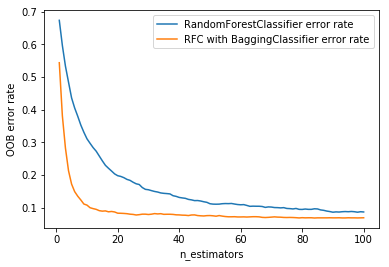

In [9]:
xs, ys = zip(*error_rate)
plt.plot(xs, ys, label='RandomForestClassifier error rate')

xs, ys = zip(*error_rate_bag)
plt.plot(xs, ys, label='RFC with BaggingClassifier error rate')
    
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Ara calculem la presició amb el conjunt X_test_pca, per veure si hi ha diferencia amb out-of-bag, que ens ha permes estimar l'error del model sense necessitat d'usar el conjunt de test:

In [10]:
from sklearn.metrics import accuracy_score

prediction_out_of_bag = bag.predict(X_test_pca)

# evaluate accuracy
accuracy = accuracy_score(y_test, prediction_out_of_bag)
print(accuracy)
print('\nLa precisió del classificador és %d%%, [%s]' % (accuracy * 100, accuracy))

0.928

La precisió del classificador és 92%, [0.928]


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> La precisió obtinguda en l'*out-of-bag* i en el conjunt de test són comparables? Era d'esperar? 
</div>

Si son comparables, són gairebe identiques, com era d'esperar la precisió obtinguda en l'out-of-bag és 93% i amb les dades de test ens surt un 92,8%, la diferencia no es significativa.

Era d'esperar, ja que els estudis de les estimacions d'errors per als classificadors encaixats de Breiman [1996b] proporciona evidències empíriques que mostren que l'estimació out-of-bag és tan precisa com l'ús d'un conjunt de proves de la mateixa mida que el conjunt d'entrenament

### 1.1.3 Probabilitat per classe (1 punt)

Una altra avantatge del *bagging* usat en el *Random Forest* és que cada un dels arbres de decisió, entrenat amb una combinació diferent de les dades, pot obtenir un resultat diferent. En els problemes de classificació, el resultat de cada arbre es considera como un vot diferent, i la predicció final del model és la classe que hagi obtingut més vots tenint en compte tots els arbres.

Aquests vots individuals dels arbres també es poden usar per a estimar la probabilitat amb la que el model preveu cada una de las classes, essent la probabilitat per a cada classe igual al número de vots obtinguts per aquella classe dividit entre el número d'arbres.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Per cada classe (etiqueta), mostra un exemple d'imatge que el model hagi classificat incorrectament juntament amb l'etiqueta assignada pel model i l'etiqueta original. Mostra també les probabilitats que el model ha atribuït a cada classe per aquestes imatges.
<hr> Suggeriment: usa el model que has entrenat en l'exercici anterior amb el mòdul *RandomForestClassifier* de sklearn i les previsions que has calculat pel conjunt de dades de test. Per mostrar les imatges, usa el codi proporcionat en la secció 0. Per aprendre més sobre el mòdul *RandomForestClassifier* de sklearn (incluint el mètode *predict_proba*), us recomanem el següent enllaç:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

Una imatge de cada classe que no s'ha classificat correctament:
Pos. 6, l'imatge s'ha predit com A, però era una B
Probabilitats A:42%, B:11%, C:10%, D:15%, E:20%
------------------------------------------------------
Pos. 26, l'imatge s'ha predit com B, però era una D
Probabilitats A:15%, B:26%, C:16%, D:24%, E:16%
------------------------------------------------------
Pos. 328, l'imatge s'ha predit com C, però era una E
Probabilitats A:6%, B:12%, C:42%, D:8%, E:29%
------------------------------------------------------
Pos. 51, l'imatge s'ha predit com D, però era una A
Probabilitats A:21%, B:23%, C:6%, D:38%, E:9%
------------------------------------------------------
Pos. 37, l'imatge s'ha predit com E, però era una D
Probabilitats A:18%, B:17%, C:14%, D:17%, E:30%
------------------------------------------------------


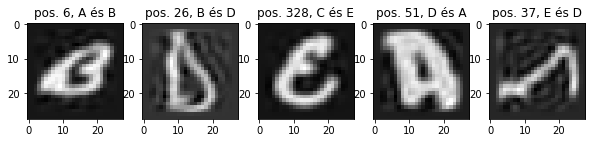

In [11]:
Error_list_index = [i for i, (j, k) in enumerate(zip(y_test, prediction_out_of_bag)) if j != k]

print('Una imatge de cada classe que no s\'ha classificat correctament:')
print('================================================================')

n_images = 5
fields = 1

A = False
B = False
C = False
D = False
E = False

list_errors_classe = []

for i in Error_list_index:
    if (prediction_out_of_bag[i] == 0 and A == False):
        list_errors_classe.append((0,i))
        A = True
    if (prediction_out_of_bag[i] == 1 and B == False):
        list_errors_classe.append((1,i))
        B = True
    if (prediction_out_of_bag[i] == 2 and C == False):
        list_errors_classe.append((2,i))
        C = True
    if (prediction_out_of_bag[i] == 3 and D == False):
        list_errors_classe.append((3,i))
        D = True
    if (prediction_out_of_bag[i] == 4 and E == False):
        list_errors_classe.append((4,i))
        E = True
        
list_errors_classe.sort()
        
fig, ax = plt.subplots(fields, n_classes, figsize=(10,10))

def get_proba(indexs):  
    return (bag.predict_proba(np.reshape(X_test_pca[indexs], (1, -1))))

for k, i in zip(list_errors_classe, range(n_classes)):
    k = k[1]    
    image = pca.inverse_transform(X_test_pca[k])
        
    print("Pos. {}, l'imatge s'ha predit com {}, però era una {}".format(k, labels_text[prediction_out_of_bag[k]], labels_text[y_test[k]]))
    per_cent_pred = get_proba(k)
    print("Probabilitats A:%d%%, B:%d%%, C:%d%%, D:%d%%, E:%d%%" % (per_cent_pred[0][0]*100, per_cent_pred[0][1] * 100, per_cent_pred[0][2]*100, per_cent_pred[0][3]*100, per_cent_pred[0][4]*100))
    print("------------------------------------------------------")
    ax[i].imshow(image.reshape(28, 28).transpose(), cmap="gray")
    ax[i].set_title("pos. %s, %s és %s" % (k,labels_text[prediction_out_of_bag[k]], labels_text[y_test[k]]))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> En aquests casos en els que el model s'ha equivocat, estava a prop de preveure l'etiqueta correcta?
</div>

No en el casos on s'ha equivocat no ha estat prop de preveure correctament, podem veure diferentices de 42% vs la correcta de un 29%, o un 30% vs la correcta de un 17%. Tot i que, podem veure que les imatges son complicades pero no ha estat prop de preveureu.

### 1.1.4 Importància de les variables (1 punt)

Una altra avantatge de l'algoritme *Random Forest* és que permet medir la importància relativa de cada variable, gràcies a que cada un dels arbres fou entrenat amb un sub-conjunt diferent de les variables originals.

En el problema de classificació d'imatges analitzat aquí, la importància de les variables ens permet saber quins són generalment els píxels més importants per poder classificar la imatge. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena un classificador *Random Forest* amb el conjunt de dades d'entrenament original *X_train*, en els que cada variable és la intensitat de cada píxel (enlloc de ser les variables PCA que hem usat anteriorment). Mostra quines són les 10 variables més importants. Fes un gràfic en el que es vegi quines zones de la imatge són més importants pel classificador.

<hr> Suggeriment: usa el mòdul *RandomForestClassifier* de sklearn per calcular la importància de les variables. Per a representar gràficament la importància de cada píxel de la imatge, usa part del codi proporcionat en la secció 0. Per aprendre més sobre el mòdul *RandomForestClassifier* de sklearn (incluïnt el mètode *feature&#95;importances_*), us recomanem el següent enllaç:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

In [12]:
## Import the random forest model.
from sklearn.ensemble import RandomForestClassifier 
## This line instantiates the model. 
forest = RandomForestClassifier() 
## Fit the model on your training data.
forest.fit(X_train, y_train) 
## And score it on your testing data.
forest.score(X_test, y_test)

0.937

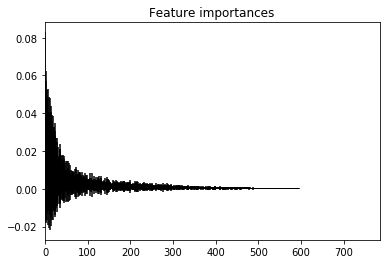

In [13]:
# Print the feature ranking
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xlim([-1, X_test.shape[1]])
plt.show()

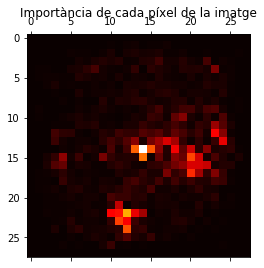

In [14]:
importances = forest.feature_importances_
importances = importances.reshape(28, 28).transpose()

# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Importància de cada píxel de la imatge")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Et sembla plausible el resultat que has obtingut? Perquè?
</div>

Sí, hem mostrat l'ús de boscos d'arbres per avaluar la importància de les característiques en una tasca de classificació artificial. 

Els píxels grocs i vermells són les característiques més importants del bosc, juntament amb la seva variabilitat entre arbres.

Com era d'esperar la zona central és on més importància hi ha per què també és on les lletres tenen més variació.

### 1.1.5 Número de classificadors (1 punt)

En els exercicis anteriors hem combinat 100 classificadors simples en un classificador combinat. Será que la precisió del classificador combinat augmenta indefinidament el seu rendiment si afegim més classificadors?

Per respondre a aquesta pregunta representarem una corba de validació. La corba de validació és una representació gràfica del rendiment d'un model variant un dels seus paràmetres. Mentre que la búsqueda de reixeta (*grid*) ens permet trobar la combinació de paràmetres que dona millors resultats, la corba de validació ens permet entendre quin és l'impacte d'un determinat paràmetre en el rendiment d'un model.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena diferents models de *Random Forest* amb un número d'arbres cada vegada més gran. Per a cada model, calcula la seva precisó en el conjunt de test o usant *cross-validation* en el conjunt d'entrenament. Opcional: representa gràficament l'evolució de la precisió amb el número d'arbres per ajudar-te en l'anàlisis dels resultats.
<hr>
Suggeriment: usar el mòdul *validation_curve* de sklearn. Per aprendre a usar aquest mòdul us recomanem els següents enllaços:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html<br>
http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
</div>

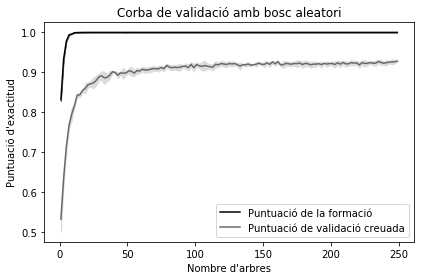

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import validation_curve

# Crea un interval de valors per al paràmetre
param_range = np.arange(1, 250, 2)

# Calculeu la precisió sobre la formació i el conjunt de proves utilitzant un interval de valors de paràmetres
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X_train_pca, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

# Calculeu la mitjana i la desviació estàndard per a les puntuacions establertes per entrenament
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculeu la mitjana i la desviació estàndard per a les puntuacions del conjunt de proves
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Puntuació mitjana de puntuacions de precisió per als entrenaments i conjunts de prova
plt.plot(param_range, train_mean, label="Puntuació de la formació", color="black")
plt.plot(param_range, test_mean, label="Puntuació de validació creuada", color="dimgrey")

# Bandes d'exactitud de traçat per entrenaments i conjunts de prova
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Creació del plot
plt.title("Corba de validació amb bosc aleatori")
plt.xlabel("Nombre d'arbres")
plt.ylabel("Puntuació d'exactitud")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Incrementa indefinidament la precisió amb el número d'arbres combinats? Si satura, ho fa a la precisió màxima o a un altre valor? Perquè?
</div>

Clarament no incrementa indefinidament la precisió amb un nombre d'arbres combinats, s'atura entre 40 i 50 arbres, i quan s'atura gairebé ho fa a la precisió màxima, almenys la diferencia no és significativa, sols augmenta molt poc.

El motiu perquè al augmentar cap cop més el número d'arbres estem sobretrenan el model fins al punt que ja no varia la precisió del model, overfitting, però deixa de ser el suficient genèric per realitzar prediccions.

### 1.1.6 Volum de dades (1 punt)

Será que entrenant el model amb més dades (més imatges) el model aprendria a classificar amb una millor precisió? En casos reals, és molt útil intentar respondre a aquesta pregunta abans d'intentar aconseguir més dades, ja que això pot ser un procés difícil, car, o que impliqui esperar molt temps.

Per respondre a aquesta pregunta, analitzarem com evoluciona la precisió del model en els conjunts d'entrenament i test per a diferents volums de dades de tamany creixent. Representar els resultats en una corba d'aprenentatge (*learning curve*) ens permetrà analitzar visualment aquestes quantitats.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena diferents models de *Random Forest* amb un volum de dades cada vegada més gran. Per a cada model, calcula la seva precisó en el conjunt d'entrenament i de test, i representa els resultats en un gràfic.
<hr>
Suggeriment: usar el mòdul *learning_curve* de sklearn. Per aprendre a usar aquest mòdul us recomanem els següents enllaços:<br>
http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve<br>
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
</div>

Utilitzem una funció http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html per poder realizar represetar graficament els resultat del score en cada volum de dades:

In [16]:
from sklearn.model_selection import learning_curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def learning_curve_plot(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

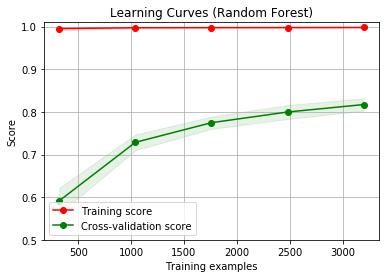

In [17]:
title = "Learning Curves (Random Forest)"
# Validació creuada amb 100 iteracions per obtenir una prova mitjana més suau i tren
# Corbes de puntuació, cada vegada amb un 20% de dades seleccionades aleatòriament com a conjunt de validació.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestClassifier()

learning_curve_plot(
    estimator,
    title,
    X=X_train_pca,
    y=y_train,
    ylim=(0.5, 1.01),
    cv=cv,
    n_jobs=4
)

plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Creus que si obtinguéssim més dades d'entrenament (més imatges classificades) milloraria el model? Perquè?
</div>

No, podem veure que a partir de 1500 imatges la puntuació del cross-validation creix molt poc, es manté en 0.8, sols estirem sobre entrenament el model i no seria capça de generalitzar bé si augmenten les imatges.

## 1.2 Boosting (1 punt)

En el sistema de *Boosting* es combinen diferents classificadors dèbils seqüencialment, i en cada un d'ells es dona més pes a les dades que han sigut erròniament classificades en les combinacions anteriors, per què el model es concentri d'aquesta manera a millorar els casos més difícils de resoldre.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Usant el conjunt *X_train_pca*, entrena un model Gradient Boosting i estima la precisió del model amb una estratègia de *cross-validation* en els mateixos conjunts. Seguidament calcula les previsions del model en el conjunt *X_test_pca* y la seva precisió en aquest conjunt.

<hr>
Suggeriment: usar els mòduls *GradientBoostingClassifier* i *cross_val_score* de sklearn. Per aprendre a usar aquest mòdul us recomanem el següent enllaç:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

In [18]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

np.random.seed(40)

#Parámetres para iterar
profunditat = range(5,30)
 
modelGradiantBoost = GradientBoostingClassifier(random_state=2008,n_estimators =100)
 
paramGrid = dict(max_depth = profunditat)

# GridSearchCV que ens permiter veure la combinatoria dels paràmetres dels nostres models i en aquest cas anem a jugar amb la funció de pèrdua, la profunditat de l'arbre, els talls mínims de l'arbre de classificació i la ràtio d'aprenentatge.
grid = GridSearchCV(modelGradiantBoost, paramGrid, cv=10, scoring='accuracy', n_jobs=5)

grid.fit(X_train_pca, y_train)
 
millorModel = modelGradiantBoost.fit(X_train_pca, y_train)

In [19]:
kfold = StratifiedKFold(n_splits=10, random_state=2008)
results = cross_val_score(millorModel, X_train_pca, y_train, cv=kfold)
print("La precisió és: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

La precisió és: 92.25% (1.33%)


La millor puntuació és 0.92725
El mètode òptim amb la profunditat dels arbres usats és 
{'max_depth': 5}


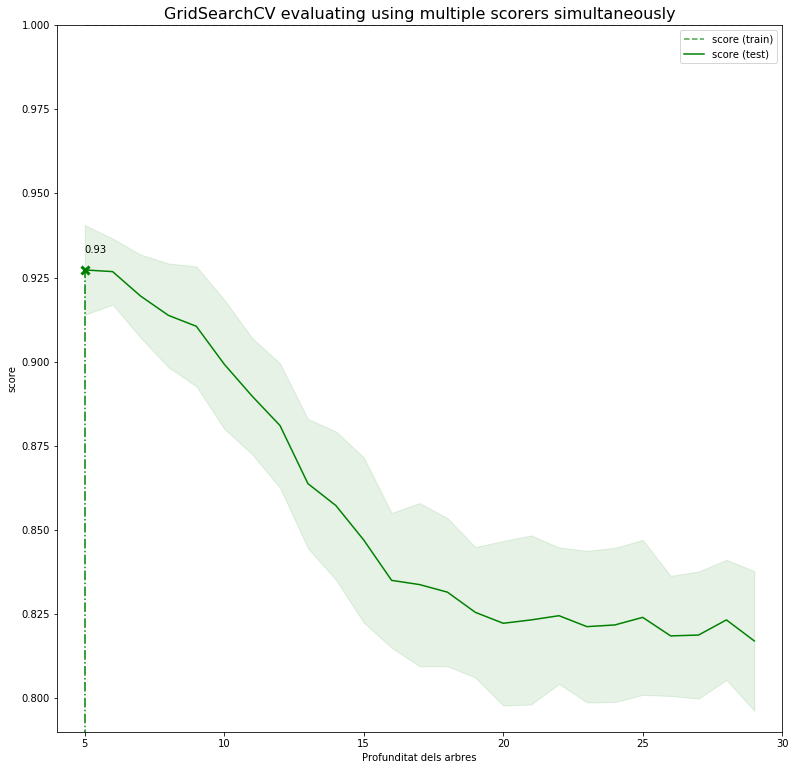

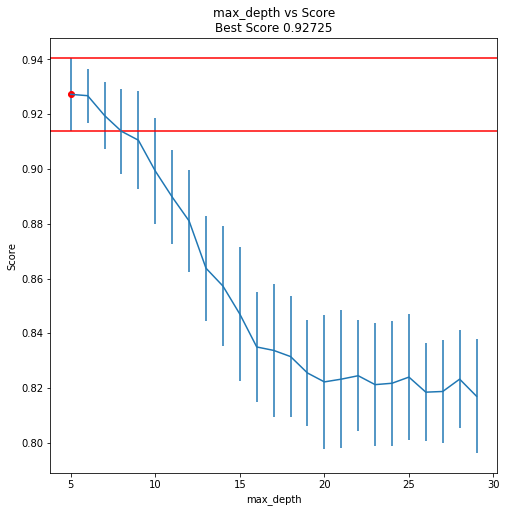

In [20]:
import pandas as pd

print("La millor puntuació és %s" % grid.best_score_)
print("El mètode òptim amb la profunditat dels arbres usats és ")
print(grid.best_params_)

results = grid.cv_results_
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("Profunditat dels arbres")
plt.ylabel("score")
plt.grid()

ax = plt.axes()
ax.set_xlim(4, 30)
ax.set_ylim(0.79,1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(['score']), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()


def grid_search_table_plot(param_name,
                          negative=True,
                          graph=True):
    scores_df = pd.DataFrame(results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']

    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(best_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()


grid_search_table_plot("max_depth", negative=False)

Podem veure graficament el funcionament del model

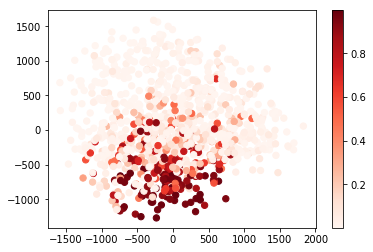

In [21]:
import pandas as pd

proba = millorModel.predict_proba(X_test_pca)
proba = pd.DataFrame(proba)[1]
  
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=40, cmap=plt.cm.Reds, c=proba)
plt.colorbar()
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> El boosting es basa en la combinació de classificadors dèbils. En la implementació que has utilitzat en aquest exercici, quina és la profunditat dels arbres usats? Compara-la amb la que vas utilitzar en els arbres de decisió de l'exercici de *bagging*.
</div>

La profunditat que he utilitzat en el boosting, ha sigut un rang entre 5 i 30 de profunditat en el cross-validation, podem veure que inicialment amb la profunditat 5 hem aconseguit a màxima puntuació. Comparada amb els random-forest de bagging, hem aconseguit gairebé la mateixa puntuació, 92% vs 93%.

Pel que fa a la profunditat si és significativa, a menor profunditat els classificadors dèbils seqüencials obtenen millor puntuació.

# 2. Combinació seqüencial de classificadors base diferents

## 2.1 Stacking (1 punt)

Un classificador d'*stacking* usa com a atributs les prediccions fetes per altres classificadors enlloc de les dades originals d'entrenament.

Per construïr el nostre classificador d'*stacking* utilitzarem les prediccions fetes en el conjunt de test pels classificadors usats en els exercicis anteriors d'aquesta pràctica, així com les d'altres classificadors. Us proporcionem les prediccions fetes sobre el mateix conjunt de test pels classificadors K-Nearest neighbors Classifier (knc), Support Vector Machines Classifier (svmc) i Neural Network Classifier (nnc) en arxius adjunts. Aquestes prediccions es poden carregar amb el següent codi: 

In [22]:
# càrrega de prediccions calculades amb altres classificadors:
preds_knc = np.load("preds_knc.pickle")
preds_svmc = np.load("preds_svmc.pickle")
preds_nnc = np.load("preds_nnc.pickle")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Construeix un classificador d'*stacking* usant una *Random Forest* que faci servir com a atributs les prediccions fetes en el conjunt de test pels algoritmes k-nn, SVM, xarxa neuronal i Gradient Boosting. Calcula la precisió del model resultant amb *cross-validation* en el conjunt de test.

<hr>
Suggeriment: usar les funcions *column_stack* de numpy y *OneHotEncoder* de sklearn per preparar les dades. Per aprendre a usar aquestes funcions us recomanem els següents enllaços:<br>
https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html<br>
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html<br>
http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features
</div>

In [23]:
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

oneHotEncoder_model = OneHotEncoder()

X_oht = oneHotEncoder_model.fit_transform(np.column_stack((preds_knc,preds_svmc,preds_nnc,proba))).toarray()

classifier = RandomForestClassifier(warm_start=True, oob_score=True, random_state=2008)

results = cross_val_score(classifier, X_oht, y_test, cv=5)

print("Precisió: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Precisió: 96.70% (1.03%)


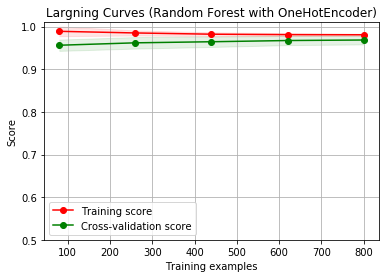

In [24]:
learning_curve_plot(
    classifier,
    "Largning Curves (Random Forest with OneHotEncoder)",
    X=X_oht,
    y=y_test,
    ylim=(0.5, 1.01),
    cv=cv,
    n_jobs=4
)

plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Has aconseguit millorar la precisió gràcies a l'*stacking*? Comenta el resultat.
</div>

Si, ha millorat de un 92% fins un 96.70% de presició, al afegir més informació al classificador millora.

## 2.2 Cascading

### 2.2.1 Cascading simple

El cas de *cascading* és semblant al de *stacking* però utilitzant no només les prediccions parcials dels classificadors base, sino també les dades originals.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Quines dades addicionals dels models anteriors podries usar per a enriquir el model? Construeix un classificador de *cascading* usant una *Random Forest* que utilitzi com a atributs els usats en l'exercici anterior més altres atributs nous que puguis obtenir d'alguns dels classificadors utilitzats en els exercicis anteriors. Calcula la precisió del model resultant amb *cross-validation* en el conjunt de test.</div>

Com el model no accepta valors negatius transformen els valors del PCA a nombres absoluts.

In [25]:
enc = OneHotEncoder()

X_enc = enc.fit_transform(np.column_stack((preds_knc,preds_svmc,preds_nnc,proba,np.absolute(X_test_pca)))).toarray()

forestClassifier = RandomForestClassifier(warm_start=True, oob_score=True, random_state=2008)

results = cross_val_score(forest, X_enc, y_test, cv=5)
print(scores)

print("Precisió: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.92    0.92875 0.9225  0.92375 0.93875]
Precisió: 96.20% (1.36%)


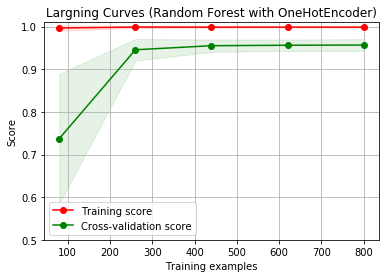

In [26]:
from sklearn.model_selection import learning_curve

learning_curve_plot(
    forestClassifier,
    "Largning Curves (Random Forest with OneHotEncoder)",
    X=X_enc,
    y=y_test,
    ylim=(0.5, 1.01),
    cv=cv
)

plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Has aconseguit millorar la precisió gràcies al *cascading*? Comenta el resultat.
</div>

No hem aconseguit millorar, en aquest cas, la puntuació de 96% hem baixat a un 95%, tot i que podríem dir que no és massa significativa la diferencia.

### 2.2.2 Cascading amb variables addicionals (1 punt)

En el *cascading* també podem afegir com a variables del model a dades addicionals que s'hagin pogut generar durant la presa de decisions dels classificadors que combinem.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Quines dades addicionals dels models anteriors podries usar per a enriquir el model? Construeix un classificador de *cascading* usant una *Random Forest* que utilitzi com a atributs els usats en l'exercici anterior més altres atributs nous que puguis obtenir d'alguns dels classificadors utilitzats en els exercicis anteriors. Calcula la precisió del model resultant amb *cross-validation* en el conjunt de test.</div>

Hem

In [27]:
forestClassifier_2 = RandomForestClassifier(warm_start=True, oob_score=True, random_state=2008)
parameters = forestClassifier_2.get_params(deep=True)

#hem agregat el prediction_out_of_bag, el proba i del pca
X_enc_2 = enc.fit_transform(np.column_stack((prediction_out_of_bag, preds_knc, preds_svmc, preds_nnc, proba, np.absolute(X_test_pca)))).toarray()

results = cross_val_score(forestClassifier_2, X_enc_2, y_test, cv=5)

print(scores)
print("Precisió: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.92    0.92875 0.9225  0.92375 0.93875]
Precisió: 95.90% (0.97%)


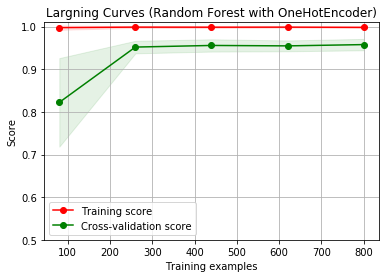

In [28]:
from sklearn.model_selection import learning_curve

learning_curve_plot(
    forestClassifier_2,
    "Largning Curves (Random Forest with OneHotEncoder)",
    X=X_enc_2,
    y=y_test,
    ylim=(0.5, 1.01),
    cv=cv
)

plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Has aconseguit millorar la precisió gràcies a afegir dades addicionals a l'*stacking*? Comenta el resultat.
</div>

No hi ha millora significativa respecte al cascading, la puntuació de contínua cent de 96% (95,90%). Per tant afegir noves variables no té perquè ser millor o obtenir millor precisió del model, és a dir, podríem provar amb altres variables però no garanteix una millora del model.

# Bibliografia
* http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html
* http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
* https://chrisalbon.com/machine_learning/model_evaluation/plot_the_validation_curve/
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html